# Johnson - Week 1: Introduction to Machine Learning

**Objectives:**
* Impute missing data (don’t just throw it away)
* Look at the data with EDA
* Drop unnecessary columns, if needed, and defend your decision to do so.
* Deal with outliers (maybe make a boxplot)
* Provide a brief summary of how you prepared your data for future analysis.

---

# 1 Setup

## 1.A Sanity Check of Provided Data File

Prior to importing any data, we perform a few checks against the file:
* What is the approximate size of the file (will our current configuration
  support the given quantity of data)?
* What is the content of the file and does it use the correct line endings?
* How many rows (lines) are in the file (can be used to double-check that
  the full dataset is loaded by Pandas)?
* Does the data have a header row?


In [1]:
%%bash
declare -a DATA_FILES=("assign_wk1/heart.disease.data")

for FILE in "${DATA_FILES[@]}"; do
    if [ -f "${FILE}" ] ; then
        echo "${FILE}:"
        echo "    Data file size:      $(du -h ${FILE} | awk '{print $1;}')"
        echo "    Data file type:      $(file --brief ${FILE})"
        echo "    Number of lines:     $(wc -l ${FILE} | awk '{print $1;}')"
        echo "    Data header row?     $(head -n 1 ${FILE})"
    else
        echo "${FILE}: NOT FOUND"
    fi
done

assign_wk1/heart.disease.data:
    Data file size:      12K
    Data file type:      CSV text
    Number of lines:     283
    Data header row?     age,sex,cp,trestbps,chol,cigs,years,fbs,dm,famhist,restecg,thalach,exang,thal,num


## 1.B Python/Jupyter Setup

We organize the imports at the begining of the notebook, similar to a
"traditional" Python file.  This is a personal preference.

Furthermore, we prefer the Python `logging` module over "raw" print statements
to stdout.

In [2]:
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.impute

# Activate the 'inline' backend such that plots are displayed directly
# after the cell containing the plot command
%matplotlib inline

# Display up to 100 rows
pd.set_option('max_row', 100)

# Set up logging ... INFO or DEBUG for my code, WARNING for libraries
logging.basicConfig(format='%(asctime)s - %(levelname)-6s - %(name)10s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S',
                    level=logging.INFO)

LOGGER = logging.getLogger('MSDS-680')


## 1.C Import the Data

* Recall from **1.A** that the file has 283 lines, so we expect
  `df_rows = 283 - 1 = 282` (because we also know the file contains a header
  row)
* Also from **1.A**, we know that there are `15` columns, based on the number
  of labels in the header row


In [3]:
# Load the file into a Pandas data frame (df)
heart_disease_df = pd.read_csv('assign_wk1/heart.disease.data')

# Verify the loaded file
df_rows, df_cols = heart_disease_df.shape
LOGGER.info(f'heart_disease_df.shape ==> {df_rows} x {df_cols} (rows x cols)')

LOGGER.info(f'First 5 rows of heart_disease_df:')
heart_disease_df.head()

2022-01-19 00:08:53 - INFO   -   MSDS-680 - heart_disease_df.shape ==> 282 x 15 (rows x cols)
2022-01-19 00:08:53 - INFO   -   MSDS-680 - First 5 rows of heart_disease_df:


,age,sex,cp,trestbps,chol,cigs,years,fbs,dm,famhist,restecg,thalach,exang,thal,num
0,63,1,1,145,233,50,20,1,-9,1,2,150,0,6,0
1,67,1,4,160,286,40,40,0,-9,1,2,108,1,3,2
2,67,1,4,120,229,20,35,0,-9,1,2,129,1,7,1
3,37,1,3,130,250,0,0,0,-9,1,0,187,0,3,0
4,41,0,2,130,204,0,0,0,-9,1,2,172,0,3,0


## 1.D Setup Conclusion

The data file is successfully imported into a Pandas data frame.  We know that
we've loaded every line and we have the correct number of columns.

Beyond that, though, we cannot assume the accuracy of the content until we
perform EDA (which we are now ready for).

# 2 Exploratory Data Analysis

## 2.A Dataset Documentation

(UC Irvine Machine Learning Repository, 1988)

**Features**:

| Column name   | Description                                               | Type              |
|---------------|-----------------------------------------------------------|-------------------|
| *age*         | age in years                                              | continuous        |
| *sex*         |                                                           | categorical $^1$  |
| *cp*          | chest pain type                                           | categorical $^2$  |
| *trestbps*    | resting blood pressure (in mm Hg)                         | continuous        |
| *chol*        | serum cholestoral in mg/dl                                | continuous        |
| *cigs*        | cigarettes per day                                        | continuous        |
| *years*       | number of years as a smoker                               | continuous        |
| *fbs*         | fasting blood sugar > 120 mg/dl                           | categorical $^3$  |
| *dm*          | history of diabetes                                       | categorical $^3$  |
| *famhist*     | family history of coronary artery disease                 | categorical $^3$  |
| *restecg*     | resting electrocardiographic results                      | categorical $^4$  |
| *thalach*     | maximum heart rate achieved                               | continuous        |
| *exang*       | exercise induced angina                                   | categorical $^3$  |
| *thal*        | Thalium Stress Test $^5$                                  | categorical $^6$  |
| ***num***     | diagnosis of heart disease (angiographic disease status)  | categorical $^7$  |

NOTES:
1. *sex* values:
   * `0`: female
   * `1`: male
2. *cp* values:
   * `1`: typical angina
   * `2`: atypical angina
   * `3`: non-anginal pain
   * `4`: asymptomatic
3. Boolean values (*fbs*, *dm*, *famhist*, *exang*)
   * `1` = yes/true
   * `0` = no/false
4. *restecg* values
   * `0`: normal
   * `1`: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
   * `2`: showing probable or definite left ventricular hypertrophy by Estes' criteria
5. Assumed, based on a Google search :)
6. *thal* values
   * `3` = normal
   * `6` = fixed defect
   * `7` = reversable defect
7. *num* values
   * `0 - 4`

**NOTE**:  There is a discrepancy in the documentation (UC Irvine Machine
           Learning Repository, 1988) where one section describes *num* as
           having two possible values and another section describes it as an
           integer valued from 0 (no presence) to 4.  Clearly, the loaded data
           ranges from `0 - 4`.

## 2.B Data Frame Overview

### 2.B.1 Data Frame Overview - Information

Based on the above column descriptions, we expect numeric content only (no
objects/strings).  `info()` will also tell us if there are any null values:

In [4]:
heart_disease_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   age       282 non-null    int64
 1   sex       282 non-null    int64
 2   cp        282 non-null    int64
 3   trestbps  282 non-null    int64
 4   chol      282 non-null    int64
 5   cigs      282 non-null    int64
 6   years     282 non-null    int64
 7   fbs       282 non-null    int64
 8   dm        282 non-null    int64
 9   famhist   282 non-null    int64
 10  restecg   282 non-null    int64
 11  thalach   282 non-null    int64
 12  exang     282 non-null    int64
 13  thal      282 non-null    int64
 14  num       282 non-null    int64
dtypes: int64(15)
memory usage: 33.2 KB


### 2.B.2 Data Frame Overview - Statistical Description

In the assignment, we were given a hint that a value of `-9` indicates a missing
measurement.  Let's see if we can prove this without the benefit of the hint...

In [5]:
heart_disease_df.describe()

,age,sex,cp,trestbps,chol,cigs,years,fbs,dm,famhist,restecg,thalach,exang,thal,num
count,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000
mean,54.411348,0.677305,3.163121,131.563830,249.092199,16.460993,14.829787,0.148936,-8.184397,0.620567,1.014184,149.765957,0.326241,4.581560,0.907801
std,9.053083,0.468338,0.955405,17.757496,51.217546,19.580300,15.564563,0.356658,2.741802,0.486108,0.998118,22.923869,0.469670,2.248467,1.224894
min,29.000000,0.000000,1.000000,94.000000,126.000000,-9.000000,-9.000000,0.000000,-9.000000,0.000000,0.000000,71.000000,0.000000,-9.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,213.000000,0.000000,0.000000,0.000000,-9.000000,0.000000,0.000000,133.250000,0.000000,3.000000,0.000000
50%,55.000000,1.000000,3.000000,130.000000,244.000000,10.000000,15.000000,0.000000,-9.000000,1.000000,2.000000,153.500000,0.000000,3.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,277.000000,30.000000,30.000000,0.000000,-9.000000,1.000000,2.000000,165.750000,1.000000,7.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,99.000000,54.000000,1.000000,1.000000,1.000000,2.000000,202.000000,1.000000,7.000000,4.000000


We see the minimum value for several columns are negative: *cigs*, *years*,
*dm*, and *thal*.  Based on the column descriptions, we don't expect any
negatives (e.g., it's meaningless to have smoked cigarrettes for `-9` years!).
Therefore, `-9` is clearly an error.  But, is it deliberately used as a
'marker' for missing values?  Let's see if there are other negative values,
which *might* indicate a different kind of data entry error:

In [6]:
for col in ['cigs', 'years', 'dm', 'thal']:
    print(f'Column: {col}')
    print(heart_disease_df[col][heart_disease_df[col] < 0].value_counts().to_string())

Column: cigs
-9    5
Column: years
-9    5
Column: dm
-9    259
Column: thal
-9    2


There are no additional negative values other than `-9`, which increases our
confidence in the marker.

Further investigation of the UCI website revealed a "Data Set Description"
file which, when downloaded, contained this snippet $^{1}$:

   Missing Attribute Values: Several.  Distinguished with value -9.0.

1. Had I seen this earlier, I might not have done as thorough an investigation,
   honestly :)

In [7]:
heart_disease_df.replace(-9, np.nan, inplace=True)
heart_disease_df.describe()

,age,sex,cp,trestbps,chol,cigs,years,fbs,dm,famhist,restecg,thalach,exang,thal,num
count,282.000000,282.000000,282.000000,282.000000,282.000000,277.000000,277.000000,282.000000,23.0,282.000000,282.000000,282.000000,282.000000,280.000000,282.000000
mean,54.411348,0.677305,3.163121,131.563830,249.092199,16.920578,15.259928,0.148936,1.0,0.620567,1.014184,149.765957,0.326241,4.678571,0.907801
std,9.053083,0.468338,0.955405,17.757496,51.217546,19.451934,15.367867,0.356658,0.0,0.486108,0.998118,22.923869,0.469670,1.939101,1.224894
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,71.000000,0.000000,3.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,213.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,133.250000,0.000000,3.000000,0.000000
50%,55.000000,1.000000,3.000000,130.000000,244.000000,10.000000,15.000000,0.000000,1.0,1.000000,2.000000,153.500000,0.000000,3.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,277.000000,30.000000,30.000000,0.000000,1.0,1.000000,2.000000,165.750000,1.000000,7.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,99.000000,54.000000,1.000000,1.0,1.000000,2.000000,202.000000,1.000000,7.000000,4.000000


# 3 Data Analysis

## 3.A Correlation

How well does each feature correlate with the outcome
(column *num*, diagnosis of heart disease)

### 3.A.1 Continuous Numerical Feature: Age vs Outcome

As seen below, an outcome of 1-4 tends to occur amongst older subjects.
Note that each histogram is depicted with `density=True` so that each bin will
display the bin's raw count divided by the total number of counts and the bin
width (Matplotlib.org, n.d.).

**Decision**: Keep `age`.  As per this week's lecture: we may want to create new
              feature for age bands.


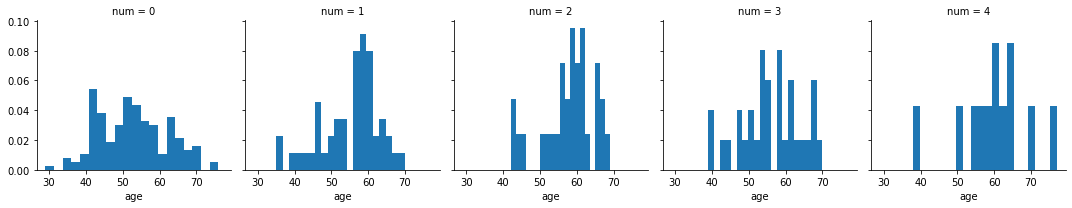

In [8]:
g = sns.FacetGrid(heart_disease_df, col='num')
g.map(plt.hist, 'age', bins=20, density=True)

### 3.A.2 Continuous Numerical Feature: Resting Blood Pressure vs Outcome

As seen below, an outcome of 1-4 seems to be related to resting blood pressure
in the higher range.

**Decision**: Keep `trestbps`.  Frankly, I don't have enough domain knowledge
              to determine if it's worthwhile to create blood pressure bands,
              nor would I know how to calculate correct ones.  This might be
              worth future investigation, though.

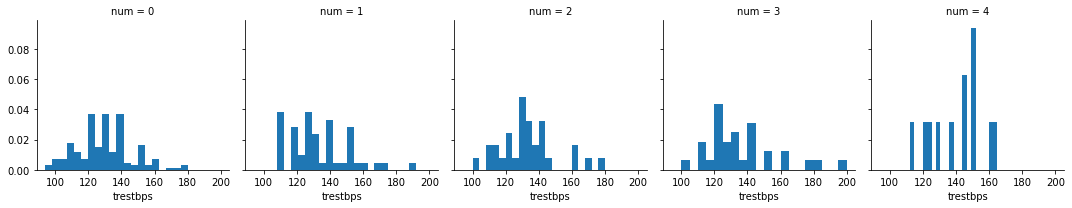

In [9]:
g = sns.FacetGrid(heart_disease_df, col='num')
g.map(plt.hist, 'trestbps', bins=20, density=True)

In [10]:
heart_disease_df[['num', 'trestbps']].groupby(['num'], as_index=False).mean().sort_values(by='num', ascending=False)


,num,trestbps
4,4,140.833333
3,3,134.968750
2,2,132.548387
1,1,133.460000
0,0,129.363057


### 3.A.3 Continuous Numerical Feature: Cholesterol vs Outcome

The relationship between cholesterol and outcome is not immediately visible
from the histograms below.  In general, though, the average cholesterol score
associated with adverse outcomes is ~250 or higher, compared to ~240 for the
positive outcome (cholesterol averaged by outcome, below).

**Decision**: Keep `chol`

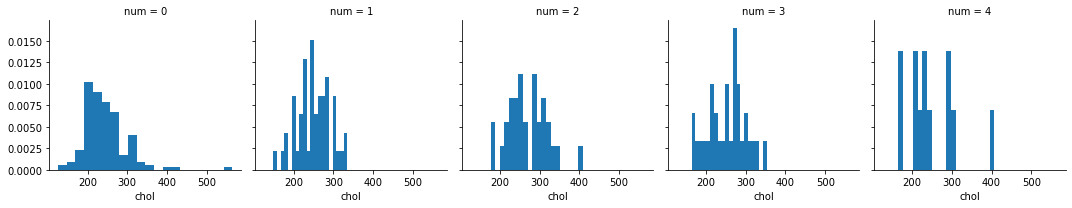

In [11]:
g = sns.FacetGrid(heart_disease_df, col='num')
g.map(plt.hist, 'chol', bins=20, density=True)

In [12]:
heart_disease_df[['num', 'chol']].groupby(['num'], as_index=False).mean().sort_values(by='num', ascending=False)


,num,chol
4,4,248.000000
3,3,253.562500
2,2,269.580645
1,1,251.020000
0,0,243.605096


### 3.A.4 Continuous Numerical Feature: Cigarettes per Day vs Outcome

**Decision**: Keep, complete `cigs`

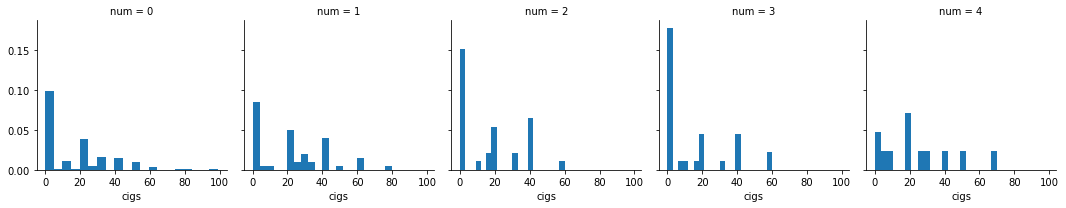

In [13]:
g = sns.FacetGrid(heart_disease_df, col='num')
g.map(plt.hist, 'cigs', bins=20, density=True)

Frankly, I'm skeptical of the exceptionally high number of cigarettes per day
(80? 100?), but I truly don't know if that's incorrect.  Fortunately, the
boxplot below shows a "reasonable" median:

2022-01-19 00:08:57 - INFO   -   MSDS-680 - Median number of cigarettes per day: 10.0


<AxesSubplot:>

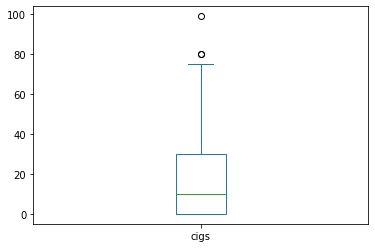

In [14]:
LOGGER.info(f'Median number of cigarettes per day: {heart_disease_df.cigs.median()}')
heart_disease_df.cigs.plot(kind='box')

In [15]:
heart_disease_df[['num', 'cigs']].groupby(['num'], as_index=False).mean().sort_values(by='num', ascending=False)


,num,cigs
4,4,24.333333
3,3,14.100000
2,2,16.225806
1,1,21.740000
0,0,15.467532


Below, we consolidate outcomes to simply be positive vs negative to try to 
clarify the relationship between cigarettes and adverse outcome.  We see that
individuals with a negative outcome average ~3.5 more cigarettes per day.

In [16]:
# This temporary DF will simply be positive vs adverse outcome
smoke_df = heart_disease_df[['num', 'cigs', 'years']]
smoke_df = smoke_df.replace(to_replace=[1, 2, 3, 4], value=[9, 9, 9, 9])
smoke_df[['num', 'cigs']].groupby(['num'], as_index=False).mean().sort_values(by='num', ascending=False)


,num,cigs
1,9,19.008130
0,0,15.688312


### 3.A.5 Continuous Numerical Feature: Years as Smoker vs Outcome

Again, at first glance the relationship between years as a smoker and outcome
isn't visually clear, but the averages show that adverse outcomes average greater
number of years as a smoker

**Decision**: Keep, complete `years`

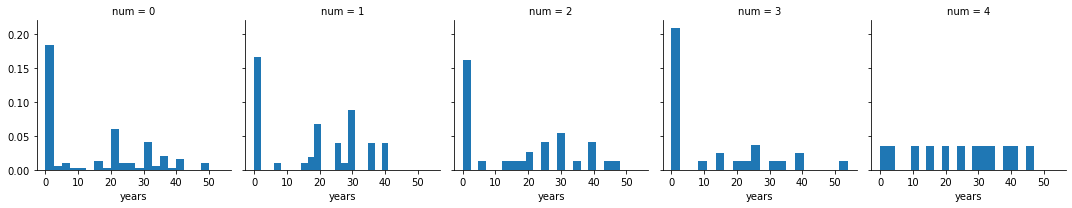

In [17]:
g = sns.FacetGrid(heart_disease_df, col='num')
g.map(plt.hist, 'years', bins=20, density=True)

In [18]:
heart_disease_df[['num', 'years']].groupby(['num'], as_index=False).mean().sort_values(by='num', ascending=False)


,num,years
4,4,24.666667
3,3,11.866667
2,2,17.225806
1,1,17.920000
0,0,13.928571


Again, we try to clarify the relationship between cigarettes and adverse
outcome.  Here, we see that individuals with a negative outcome average ~3
more years of smoking cigarettes.

In [19]:
smoke_df[['num', 'years']].groupby(['num'], as_index=False).mean().sort_values(by='num', ascending=False)


,num,years
1,9,17.097561
0,0,14.045455


### 3.A.6 Continuous Numerical Feature: Max Heart Rate vs Outcome

The link between Max Heart Rate and Outcome is not obvious.  However, after
researching `thalach`, this feature is addressed further in 3.D.1.

**Decision**: See 3.D.1

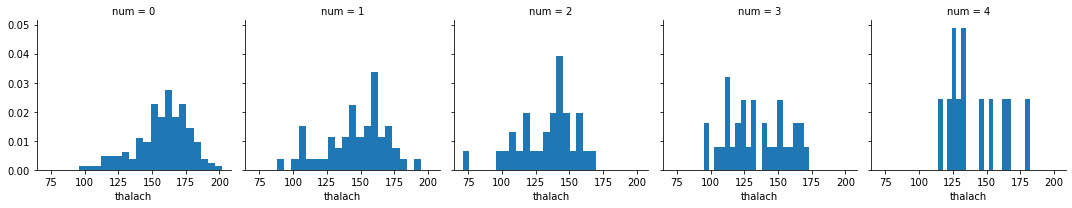

In [20]:
g = sns.FacetGrid(heart_disease_df, col='num')
g.map(plt.hist, 'thalach', bins=20, density=True)

### 3.A.7 Combined Categorical Feature: Chest Pain vs Age vs Outcome

Reminder: *cp* values:
   * `1`: typical angina
   * `2`: atypical angina
   * `3`: non-anginal pain
   * `4`: asymptomatic

   Below, we see that the majority of patients across all ages either
   1. Had chest pain but still achieved a positive outcome (first column, which
      shows `cp` `1-3` and `num == 0`)
   2. Had no chest pain, regardless of outcome (last row, which shows `cp == 4`
      and `num` `0-4`)

We do see some interplay between *non-anginal pain* (`cp == 3`) and a negative
outcome.

**Decision**: Keep `cp`

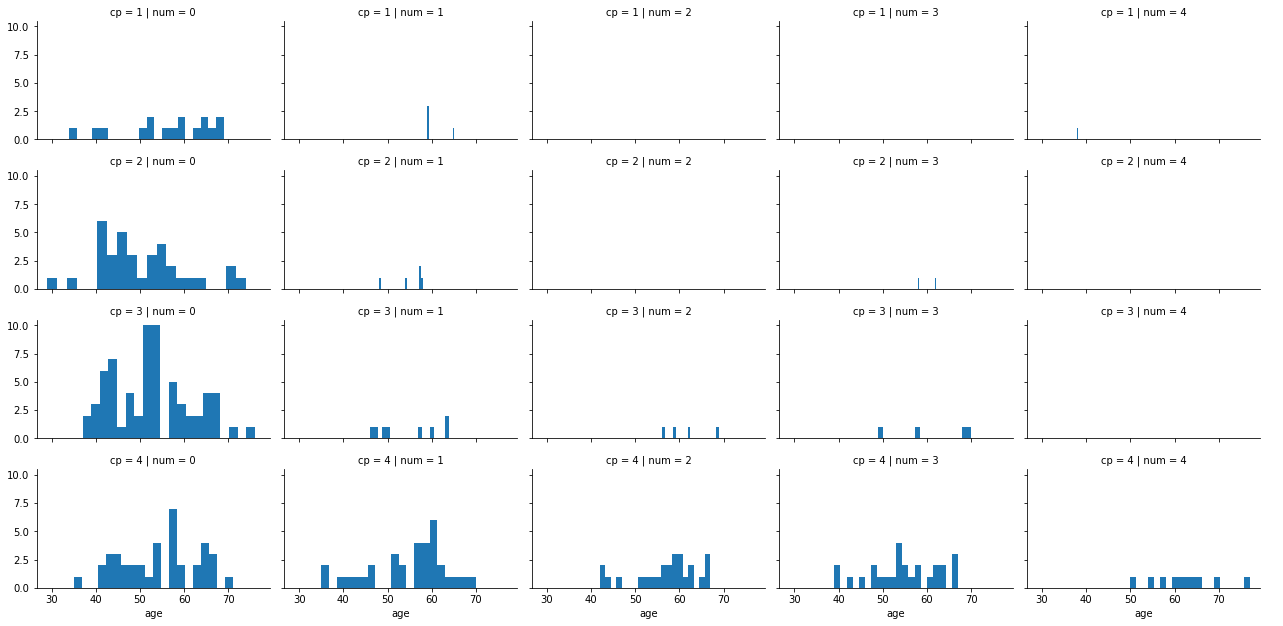

In [21]:
grid = sns.FacetGrid(heart_disease_df, col="num", row='cp', height=2.2, aspect=1.6)
grid.map(plt.hist, 'age', bins=20)
grid.add_legend()

### 3.A.8 Combined Categorical Feature: Fasting Blood Sugar vs Age vs Outcome

It appears that *very few* patients had fasting blood sugar > 120 mg/ (second
row) and also had a positive outcome (left-most cell).

**Decision**: Keep `fbs`

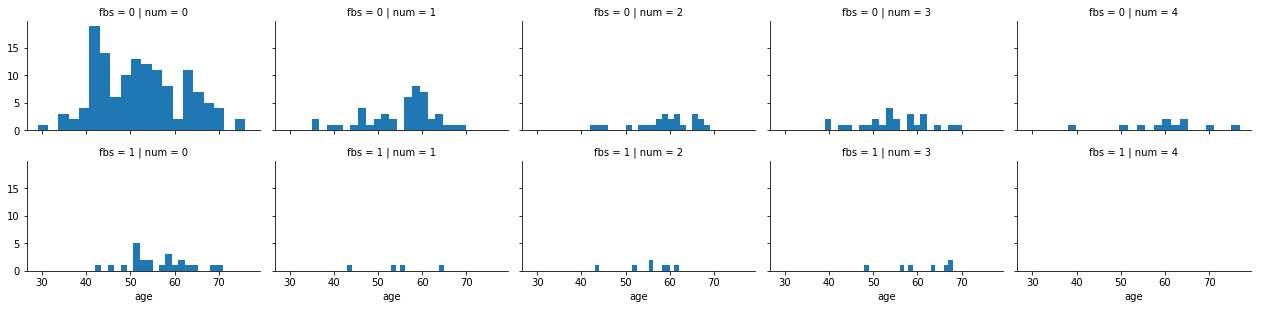

In [22]:
grid = sns.FacetGrid(heart_disease_df, col="num", row='fbs', height=2.2, aspect=1.6)
grid.map(plt.hist, 'age', bins=20)
grid.add_legend()

### 3.A.9 Combined Categorical Feature: Family History vs Age vs Outcome

The second row indicates that patients with a family history of coronary
artery disease do have a higher representation in the adverse outcomes than
those with no such history.

**Decision**: Keep `famhist`

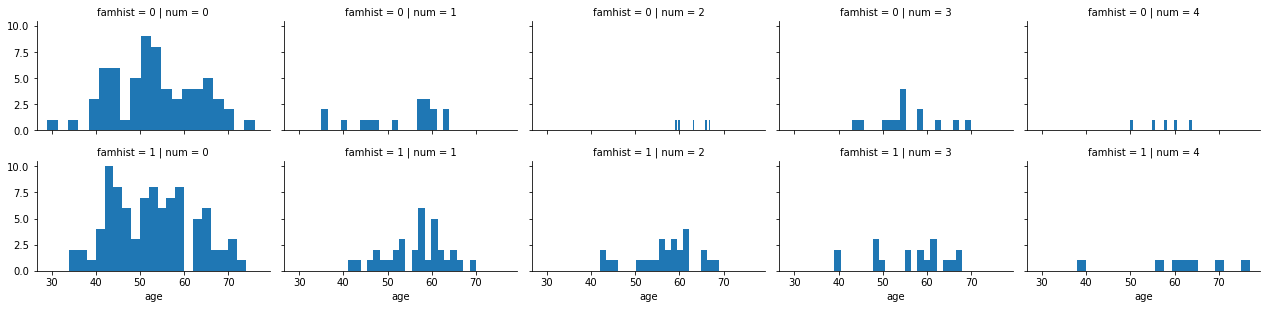

In [23]:
grid = sns.FacetGrid(heart_disease_df, col="num", row='famhist', height=2.2, aspect=1.6)
grid.map(plt.hist, 'age', bins=20)
grid.add_legend()

### 3.A.10 Combined Categorical Feature: Resting ECG Results vs Age vs Outcome

Reminder: *restecg* values
   * `0`: normal
   * `1`: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
   * `2`: showing probable or definite left ventricular hypertrophy by Estes' criteria

Again, the averages show a difference in ECG results by outcome.

**Decision**: Keep `restecg`

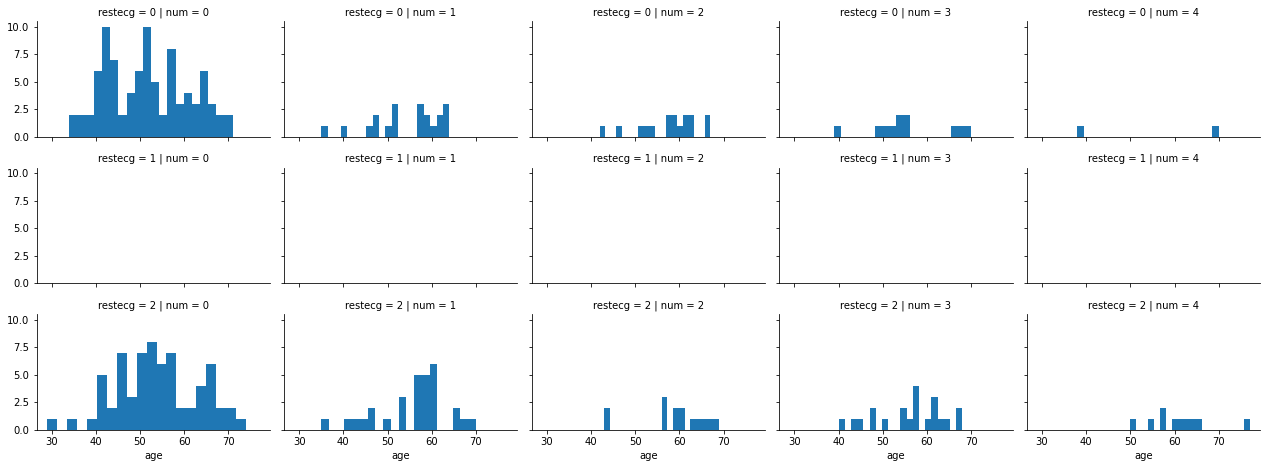

In [24]:
grid = sns.FacetGrid(heart_disease_df, col="num", row='restecg', height=2.2, aspect=1.6)
grid.map(plt.hist, 'age', bins=20)
grid.add_legend()

In [25]:
heart_disease_df[['num', 'restecg']].groupby(['num'], as_index=False).mean().sort_values(by='num', ascending=False)


,num,restecg
4,4,1.666667
3,3,1.312500
2,2,0.935484
1,1,1.200000
0,0,0.859873


### 3.A.11 Combined Categorical Feature: Exercise Induced Angina vs Age vs Outcome

Relatively speaking, very few patients with execise-induced angina had a postive
outcome, as indicated by the lower-left-most cell.

**Decision**: Keep `exang`

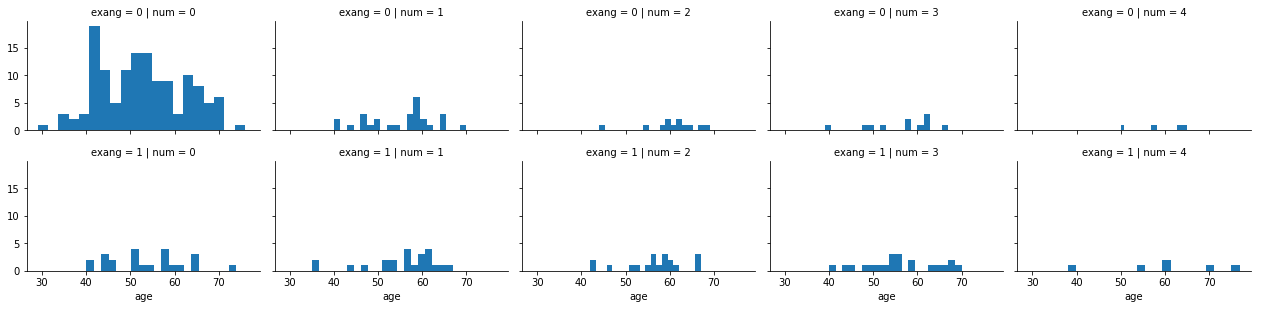

In [26]:
grid = sns.FacetGrid(heart_disease_df, col="num", row='exang', height=2.2, aspect=1.6)
grid.map(plt.hist, 'age', bins=20)
grid.add_legend()

### 3.A.12 Combined Categorical Feature: Thalium Stress Test vs Age vs Outcome

Reminder: *thal* values
   * `3` = normal
   * `6` = fixed defect
   * `7` = reversable defect

Relatively speaking, very few patients that had a *normal* Thalium Stress test
had a negative outcome.  Conversely, very few patients that *reversable defect*
result had a postive outcome.

**Decision**: Keep `thal`

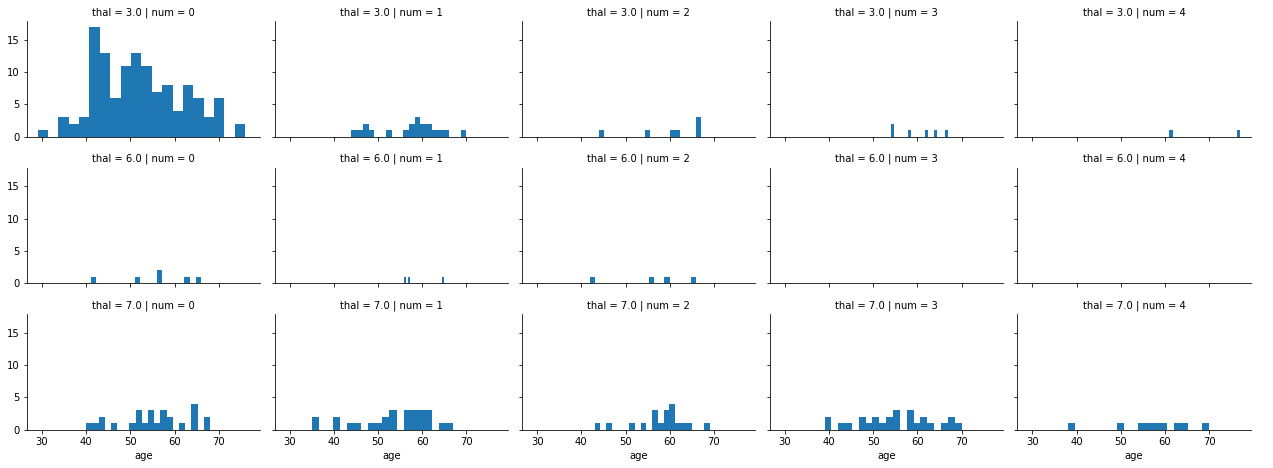

In [27]:
grid = sns.FacetGrid(heart_disease_df, col="num", row='thal', height=2.2, aspect=1.6)
grid.map(plt.hist, 'age', bins=20)
grid.add_legend()

## 3.B Completing

From 2.B.2, recall that `cigs`, `years`, `dm`, and `thal` contain NaN.  We will
address `cigs`, `years`, and `thal` in this section and `dm` in 3.C.

Before we begin completing missing values, let's collect some information
about those missing values so that we can double-check the changes after they're
made.

In [28]:
# First, we identify the indices of the missing data
test_df = pd.DataFrame(heart_disease_df[['cigs', 'years', 'thal', 'sex']])
test_df[test_df.isnull().any(axis=1)]

,cigs,years,thal,sex
21,NaN,NaN,3.0,0
23,NaN,NaN,7.0,1
87,0.0,0.0,NaN,0
159,2.0,NaN,7.0,1
182,NaN,1.0,3.0,1
195,NaN,NaN,3.0,1
250,NaN,NaN,6.0,1
266,0.0,0.0,NaN,1


Also, before we address missing `cigs` (3.B.1) or `years` (3.B.2), we note that
`sex` seems to play a large role in both.


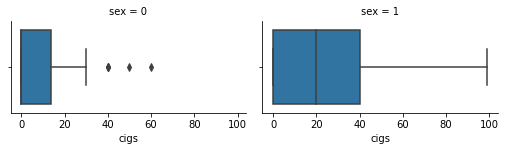

In [29]:
grid = sns.FacetGrid(heart_disease_df, col="sex", height=2.2, aspect=1.6)
grid.map(sns.boxplot, 'cigs', order=[0, 1])
grid.add_legend()

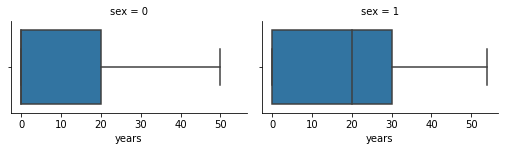

In [30]:
grid = sns.FacetGrid(heart_disease_df, col="sex", height=2.2, aspect=1.6)
grid.map(sns.boxplot, 'years', order=[0, 1])
grid.add_legend()

Finally, one more "pre-requisite" step before we replace the values.

Below, we create the User Defined Function which will be used to `apply` the
changes to the Data Frame

In [31]:
def fill_with_median(row, column_name, filter_by_col = None):
    ''' A user-defined function to return a new Pandas Series with the
        median column value (depending on the passed 'column_name'),
        if the field is NaN

        column_name -   the name of the column to be updated ... obviously, this
                        column is also used to derive the median value
        filter_by_col - an option column name to filter by.  If specified, the
                        column will be filtered to match the current
                        row's value for that column prior to calculating the
                        median.
    '''
    result = pd.Series(row)
    if np.isnan(row[column_name]):
        if filter_by_col:
            result[column_name] = heart_disease_df[heart_disease_df[filter_by_col] == row[filter_by_col]][column_name].median()
        else:
            result[column_name] = heart_disease_df[column_name].median()
    return result



### 3.B.1 Cigarettes (Continuous Numerical Feature)

Complete missing values of `cigs` using the *median* value by `sex`.

Then, test the result to ensure that we replaced with the correct values

**NOTE**: I considered re-doing this section in favor of banding *first*, then
          completing the missing values... Ultimately, I have left it in the
          order in which it occurred to me to perform, but I'm not sure if it
          makes a difference.

In [32]:
heart_disease_df = heart_disease_df.apply(fill_with_median, axis='columns', args=('cigs',), filter_by_col='sex')

# Test each index location where cig was previously NaN (captured above)
for iloc in [21, 23, 182, 195, 250]:
    current_sex = heart_disease_df.iloc[iloc]['sex']
    expected_cigs = heart_disease_df[heart_disease_df.sex == current_sex]['cigs'].median()

    assert heart_disease_df.iloc[iloc]['cigs'] == expected_cigs

### 3.B.2 Years (Continuous Numerical Feature)

Complete missing values of `years` using the *median* value by `sex`

Then, test the result to ensure that we replaced with the correct values.

In [33]:
heart_disease_df = heart_disease_df.apply(fill_with_median, axis='columns', args=('years',), filter_by_col='sex')

# Test each index location where cig was previously NaN (captured above)
for iloc in [21, 23, 159, 195, 250]:
    current_sex = heart_disease_df.iloc[iloc]['sex']
    expected_years = heart_disease_df[heart_disease_df.sex == current_sex]['years'].median()
    assert heart_disease_df.iloc[iloc]['years'] == expected_years

### 3.B.3 Thal (Categorical Feature)

Again, we will use the *median* value for `thal` to replace missing values

In [34]:
heart_disease_df = heart_disease_df.apply(fill_with_median, axis='columns', args=('thal',))

# Test each index location where cig was previously NaN (captured above)
for iloc in [87, 266]:
    assert heart_disease_df.iloc[iloc]['thal'] == heart_disease_df['thal'].median()

## 3.C Correcting

### 3.C.1 DM - Diabetes History (`dm`)

According to the documentation, `dm` is supposed to be either `0` or `1`

Some thoughts...
1. The values that are present for `dm` do not represent a sample of the
   population as whole (only representation of *yes* group, no representation
   from the *no* group).
2. In contrast, each of the other series with missing values have *some*
   representation from each of their possible values
3. We could guess that it's a data-entry issue and that all of the `-9`
   (e.g., *missing* values) were intended to be `0` (MNAR??), but this is not
   supported by justifiable evidence, it's only conjecture

**Decision**: Drop column *dm* due to the inability to reliably impute the
              missing data.

**Note**: This is different from saying the *dm* column is not *necessary*

In [35]:
LOGGER.info(f'Number of NaN in dm column: {heart_disease_df.dm.isna().sum()}')
heart_disease_df.drop(columns=['dm'], inplace=True)

2022-01-19 00:09:17 - INFO   -   MSDS-680 - Number of NaN in dm column: 259


## 3.D Creating

### 3.D.1 Delta Maximum Heart Rate

According to Charles River Medical Associates (2018), in a cardiac stress-test,
a patient should be able to achieve a heart rate equivalent to `220 - <age>`.
The test ist stopped early (prior to reaching the target heart rate) if the
patient experiences difficulty.

Therefore, we create a new feature (`delta_thalach`) which calculates the
difference between the target heart rate (`220 - age`) and the heart rate
actually achieved by the patient (`thalach`).

The new feature shows a striking difference for the outcomes!

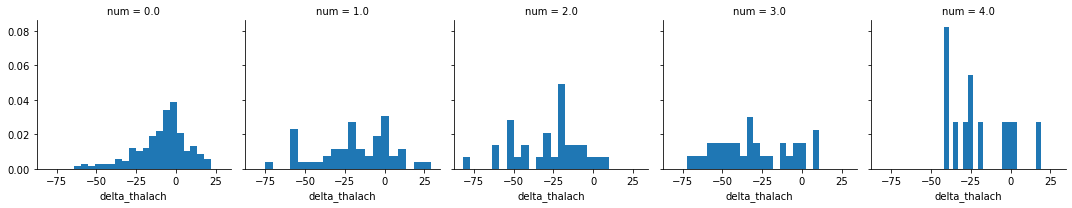

In [36]:
heart_disease_df['delta_thalach'] = heart_disease_df['thalach'] - 220 + heart_disease_df['age']
heart_disease_df.drop(columns=['thalach'], inplace=True)

g = sns.FacetGrid(heart_disease_df, col='num')
g.map(plt.hist, 'delta_thalach', bins=20, density=True)

In [37]:
heart_disease_df[['num', 'delta_thalach']].groupby(['num'], as_index=False).mean().sort_values(by='num', ascending=False)


,num,delta_thalach
4,4.0,-19.500000
3,3.0,-30.125000
2,2.0,-28.387097
1,1.0,-18.640000
0,0.0,-9.248408


### 3.D.2 Age Band

Below, we create age bands similar to this week's lessons.  By experimentation,
it appears that 10 bands give better granularity.

In [38]:
heart_disease_df['AgeBand'] = pd.cut(heart_disease_df['age'], 10)
heart_disease_df[['AgeBand', 'num']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

,AgeBand,num
0,"(28.952, 33.8]",0.000000
1,"(33.8, 38.6]",0.750000
2,"(38.6, 43.4]",0.500000
3,"(43.4, 48.2]",0.527778
4,"(48.2, 53.0]",0.644444
5,"(53.0, 57.8]",1.044444
6,"(57.8, 62.6]",1.305085
7,"(62.6, 67.4]",1.125000
8,"(67.4, 72.2]",1.000000
9,"(72.2, 77.0]",1.333333


In [39]:
heart_disease_df.loc[ heart_disease_df['age'] <= 34, 'age'] = 0
heart_disease_df.loc[(heart_disease_df['age'] >  34) & (heart_disease_df['age'] <= 39), 'age'] = 1
heart_disease_df.loc[(heart_disease_df['age'] >  39) & (heart_disease_df['age'] <= 43), 'age'] = 2
heart_disease_df.loc[(heart_disease_df['age'] >  43) & (heart_disease_df['age'] <= 48), 'age'] = 3
heart_disease_df.loc[(heart_disease_df['age'] >  48) & (heart_disease_df['age'] <= 53), 'age'] = 4
heart_disease_df.loc[(heart_disease_df['age'] >  53) & (heart_disease_df['age'] <= 58), 'age'] = 5
heart_disease_df.loc[(heart_disease_df['age'] >  58) & (heart_disease_df['age'] <= 63), 'age'] = 6
heart_disease_df.loc[(heart_disease_df['age'] >  63) & (heart_disease_df['age'] <= 67), 'age'] = 7
heart_disease_df.loc[(heart_disease_df['age'] >  67) & (heart_disease_df['age'] <= 72), 'age'] = 8
heart_disease_df.loc[ heart_disease_df['age'] >  72, 'age'] = 9
heart_disease_df.drop(columns=['AgeBand'], inplace=True)
heart_disease_df.head()

,age,sex,cp,trestbps,chol,cigs,years,fbs,famhist,restecg,exang,thal,num,delta_thalach
0,6.0,1.0,1.0,145.0,233.0,50.0,20.0,1.0,1.0,2.0,0.0,6.0,0.0,-7.0
1,7.0,1.0,4.0,160.0,286.0,40.0,40.0,0.0,1.0,2.0,1.0,3.0,2.0,-45.0
2,7.0,1.0,4.0,120.0,229.0,20.0,35.0,0.0,1.0,2.0,1.0,7.0,1.0,-24.0
3,1.0,1.0,3.0,130.0,250.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,4.0
4,2.0,0.0,2.0,130.0,204.0,0.0,0.0,0.0,1.0,2.0,0.0,3.0,0.0,-7.0


### 3.D.3 Cigs Bands

Inspired by the simplicity of creating bands for `age` and assuming that the
general proclivity for using cigarettes is more significant than the exact
number of years, we band the `cigs` values.

*This also has the nice effect of handling outliers*.

In [40]:
heart_disease_df['CigsBand'] = pd.cut(heart_disease_df['cigs'], 7)
heart_disease_df[['CigsBand', 'num']].groupby(['CigsBand'], as_index=False).mean().sort_values(by='CigsBand', ascending=True)

,CigsBand,num
0,"(-0.099, 14.143]",0.843972
1,"(14.143, 28.286]",0.954545
2,"(28.286, 42.429]",1.019231
3,"(42.429, 56.571]",0.555556
4,"(56.571, 70.714]",1.500000
5,"(70.714, 84.857]",0.333333
6,"(84.857, 99.0]",0.000000


In [41]:
# Note that we manually ensure that 0 gets its own band
heart_disease_df.loc[ heart_disease_df['cigs'] ==  0, 'cigs'] = 0
heart_disease_df.loc[(heart_disease_df['cigs'] >   0) & (heart_disease_df['cigs'] <= 10), 'cigs'] = 1
heart_disease_df.loc[(heart_disease_df['cigs'] >  10) & (heart_disease_df['cigs'] <= 20), 'cigs'] = 2
heart_disease_df.loc[ heart_disease_df['cigs'] >  20, 'cigs'] = 3
heart_disease_df.drop(columns=['CigsBand'], inplace=True)
heart_disease_df.head()

,age,sex,cp,trestbps,chol,cigs,years,fbs,famhist,restecg,exang,thal,num,delta_thalach
0,6.0,1.0,1.0,145.0,233.0,3.0,20.0,1.0,1.0,2.0,0.0,6.0,0.0,-7.0
1,7.0,1.0,4.0,160.0,286.0,3.0,40.0,0.0,1.0,2.0,1.0,3.0,2.0,-45.0
2,7.0,1.0,4.0,120.0,229.0,2.0,35.0,0.0,1.0,2.0,1.0,7.0,1.0,-24.0
3,1.0,1.0,3.0,130.0,250.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,4.0
4,2.0,0.0,2.0,130.0,204.0,0.0,0.0,0.0,1.0,2.0,0.0,3.0,0.0,-7.0


### 3.D.4 Years Bands

Similar explanation as 3.D.3

In [42]:
# Note that we manually ensure that 0 gets its own band
heart_disease_df.loc[ heart_disease_df['years'] ==  0, 'years'] = 0
heart_disease_df.loc[(heart_disease_df['years'] >   0) & (heart_disease_df['years'] <= 10), 'years'] = 1
heart_disease_df.loc[(heart_disease_df['years'] >  10) & (heart_disease_df['years'] <= 20), 'years'] = 2
heart_disease_df.loc[(heart_disease_df['years'] >  20) & (heart_disease_df['years'] <= 30), 'years'] = 3
heart_disease_df.loc[(heart_disease_df['years'] >  30) & (heart_disease_df['years'] <= 40), 'years'] = 4
heart_disease_df.loc[ heart_disease_df['years'] >  40, 'years'] = 5
heart_disease_df.head()

,age,sex,cp,trestbps,chol,cigs,years,fbs,famhist,restecg,exang,thal,num,delta_thalach
0,6.0,1.0,1.0,145.0,233.0,3.0,2.0,1.0,1.0,2.0,0.0,6.0,0.0,-7.0
1,7.0,1.0,4.0,160.0,286.0,3.0,4.0,0.0,1.0,2.0,1.0,3.0,2.0,-45.0
2,7.0,1.0,4.0,120.0,229.0,2.0,4.0,0.0,1.0,2.0,1.0,7.0,1.0,-24.0
3,1.0,1.0,3.0,130.0,250.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,4.0
4,2.0,0.0,2.0,130.0,204.0,0.0,0.0,0.0,1.0,2.0,0.0,3.0,0.0,-7.0


In [45]:
cols_at_end = ['num']
heart_disease_df = heart_disease_df[[c for c in heart_disease_df if c not in cols_at_end] 
        + [c for c in cols_at_end if c in heart_disease_df]]
heart_disease_df.to_csv('data/heart.disease.data-cleaned.csv')

# 4 Summary

- During the setup phase (Section 1), we first performed a sanity check of 
  the raw data set (prior to importing into Pandas).  Then we set up our Python
  configuration and performed the import.  Finally, we verified that the
  imported data matched the expectations based on analyzing the raw file.

- After importing the data, we performed an initial exploration of the data
  (Section 2).  We first performed some internet research to determine the
  meaning of each column and its expected values.  Then, we used the Pandas
  built-in functions `info()` and `describe()` to determine the contents of each
  column (object, numeric, etc.).  For this dataset, we confirmed that the
  special value `-9` actually indicates a missing value.

- In Section 3, we performed a deeper analysis by looking for relationships
  between two or more Features of the data set (Section 3.A, Corrlation).
  We then (Section 3.B) completed the `cigs`, `years`, and `thal` columns by
  calculating replacement values for this which are missing.  We removed the
  `dm` column due to insufficient data to complete the missing values (Section
  3.D).  Finally, we created an additional column (`delta_thalach`) based on
  `thalach` and `age` (and subsequently removed `thalach`) and then we
  performed banding for `age`, `cigs`, and `years`.

# References

* UC Irvine Machine Learning Repository (1988).  Heart disease dataset.  Retrieved from http://archive.ics.uci.edu/ml/datasets/heart+Disease

* Matplotlib.org (n.d.).  matplotlib.pyplot.hist.  Retrieved from  https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html

* Charles River Medical Associates (2018, January).  What is A Normal Heart Rate Under a Stress Test for Adults?  Retrieved from https://www.charlesrivermed.com/normal-heart-rate-stress-test/